# Twitter Bot Classifier 

## Integrating machine learning to detect bots

Over the past ten plus years, Twitter has explosively evolved into a major communication hub. "Its primary purpose is to connect people and allow people to share their thoughts with a big audience. Twitter can also be a very helpful platform for growing a following and providing your audience with valuable content before they even become customers" [Hubspot](https://blog.hubspot.com/marketing/what-is-twitter). However, not all accounts are genuine users. According to a Twitter SEC filing in 2017, Twitter estimated 8.5% of all users to be bots. To validate the credibility of communication exchanged on the platform, efforts in identifying spam bots will help improve the user's experience on twitter. 

In this project, we will be using [The Fake Project](https://botometer.iuni.iu.edu/bot-repository/datasets.html) collected by S. Cresci, R. Di Pietro, M. Petrocchi, A. Spognardi, M. Tesconi in 2017. 

We'll begin with exploring traits between genuine and bot accounts. Then, we will use several supervised learning models (Logistic Regression, Random Forest, Neural Networks) to create a Twitter bot classifier. Finally, we'll use clustering to identify certain specific behavioral groups of accounts. 


### Overview of Data
We'll be using 4 data tables from the Fake Project: 
 * __genuine accounts__: randomly sampled human-operated accounts verified through responses of questions in natural language (2011)
 * __social spambots #1__: retweeters of an Italian political candidate (2012)
 * __social spambots #2__: spammers of #TALNTS (paid apps) for mobile devices (2014)
 * __social spambots #3__: spammers of products(URLs) on sale at Amazon.com (2011)
 
Each dataset contains two tables: tweets and users.

We concatenated all tweets tables to form an aggregate tweets table. The same method will be applied for users tables. For more information regarding the collection of data: [The Paradigm-Shift of Social Spambots:
Evidence, Theories, and Tools for the Arms Race](http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/companion/p963.pdf)

### Workflow 
1. Experimental Dataset 
2. Exploratory Data Analysis
3. Subsampling 
4. Feature Engineering and Text Preprocessing
5. Supervised Learning: Building a Bot Classifier 
7. Unsupervised Learning Models: Tweet Segmentation
8. Conclusion

In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

#NLP tools
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# NLP feature selection 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Reduce Dimensions
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# Sklearn data clean
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score,accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Reduce Dimension 
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Clustering 
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

# Hierarchy clustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Math 
import math
from scipy.stats import kurtosis, skew

# Datetime
from datetime import datetime
from dateutil import parser
import time

# Import data
import warnings

## Import Data

In [2]:
tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_tweets2')
users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_users2')

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               object
timestamp                object
crawled_at               object
updated                  object
class                    int64
dtypes: int64(12), object(6)
memory usage: 862.9+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

### Convert time variables to datetime 
It doesn't appear that time variables such as timestamp or created_at were saved as datetime. We will convert them to their respective data type. 

In [5]:
# Convert the time columns to np.datetime object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

In [6]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [7]:
tweets['crawled_at'] = pd.to_datetime(tweets['crawled_at'])

In [8]:
tweets['updated'] = pd.to_datetime(tweets['updated'])

In [9]:
# Convert the created_at column to np.datetime object
users['timestamp'] = pd.to_datetime(users['timestamp'])

In [10]:
users['created_at'] = pd.to_datetime(users['created_at'])

In [11]:
users['crawled_at'] = pd.to_datetime(users['crawled_at'])

In [12]:
users['updated'] = pd.to_datetime(users['updated'])

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               datetime64[ns, UTC]
timestamp                datetime64[ns]
crawled_at               datetime64[ns]
updated                  datetime64[ns]
class                    int64
dtypes: datetime64[ns, UTC](1), datetime64[ns](3), int64(12), object(2)
memory usage: 862.9+ MB


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

In [15]:
tweets.head()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
0,515447020405137408,"""Il mare d'inverno è un concetto che il pensie...","<a href=""http://www.Matildadr89.com"" rel=""nofo...",237359828,0,0,0,0,0,0,0,0,0,2014-09-26 10:25:20+00:00,2014-09-26 12:25:20,2014-11-13 01:35:24,2014-11-13 01:35:24,1
1,513551196226093057,Read the History of Corona Beer http://t.co/Z...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",215693377,0,0,0,0,0,0,0,1,0,2014-09-21 04:52:01+00:00,2014-09-21 06:52:01,2014-11-12 23:35:05,2014-11-12 23:35:05,1
2,579534763872149504,After that it would of been up to the person i...,"<a href=""http://twitter.com/download/iphone"" r...",164284493,0,0,0,0,0,0,0,0,0,2015-03-22 06:47:09+00:00,2015-03-22 07:47:09,2015-05-01 13:21:46,2015-05-01 13:21:46,0
3,449751137970028544,RT @kcivey: @marionbarryjr I'm for public fina...,"<a href=""http://twitter.com/download/iphone"" r...",225683965,0,0,449735142085779456,1,0,0,0,0,2,2014-03-29 03:33:21+00:00,2014-03-29 04:33:21,2015-05-01 15:58:20,2015-05-01 15:58:20,0
4,589197488269045760,RT @specuIar: This hit me hard. http://t.co/rY...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",505440359,0,0,589196377353097216,1300,0,0,0,0,1,2015-04-17 22:43:22+00:00,2015-04-18 00:43:22,2015-05-01 13:21:33,2015-05-01 13:21:33,0


In [16]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,created_at,timestamp,crawled_at,updated,class
0,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-18 11:22:38+00:00,2014-02-18 12:22:38,2014-05-03 00:22:39,2016-03-15 15:20:24,1
1,343263643,RIP Teveon ,youpettihoe_,36513,2166,1627,2977,0,en,http://pbs.twimg.com/profile_images/5594447898...,...,FFFFFF,FFFFFF,http://pbs.twimg.com/profile_background_images...,FFFAFF,0A7A00,2011-07-27 09:01:04+00:00,2011-07-27 11:01:04,2015-05-01 23:18:23,2016-03-15 16:11:13,0
2,531154412,Bulah Lynne,Lynnevibe,10657,1194,996,1,8,en,http://pbs.twimg.com/profile_images/1914097815...,...,C0DEED,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,2012-03-20 11:48:05+00:00,2012-03-20 12:48:05,2014-05-05 23:24:32,2016-03-15 15:40:08,1
3,2377665366,Katherina Kistle,KatherinaKistle,37,0,38,0,0,en,http://pbs.twimg.com/profile_images/4430041788...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-03-07 21:23:35+00:00,2014-03-07 22:23:35,2014-05-05 00:21:50,2016-03-15 15:16:15,1
4,3015346510,Lindsay Blessing Fan,lindsayspainfan,96,43,113,425,0,es,http://pbs.twimg.com/profile_images/5631073115...,...,000000,000000,http://pbs.twimg.com/profile_background_images...,000000,9266CC,2015-02-03 20:49:38+00:00,2015-02-03 21:49:38,2015-05-02 01:09:46,2016-03-15 16:07:16,0


# Exploratory Data Analysis
We'll start by exploring the Tweets table by keeping a few questions in mind.<br> 
__How many tweets were made by humans and robots?__ <br>
__Which accounts posted the most tweets?__ <br>

In [17]:
# Bot vs human tweets 
counts = tweets['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} tweets made by humans({:.3f}%) and {} tweets made by bots ({:.3f}%) in the tweets table.'.format(human, human_per, bot, bot_per))

There are 2826718 tweets made by humans(44.987%) and 3456718 tweets made by bots (55.013%) in the tweets table.


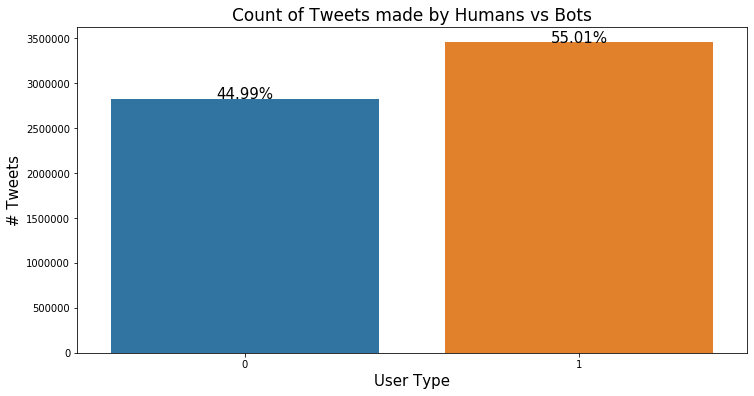

In [18]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = tweets)
g.set_title('Count of Tweets made by Humans vs Bots', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Tweets', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(tweets) * 100),
            ha="center", fontsize=15) 

As shown in the bar graph, the data consists of 45% tweets by humans and 55% tweets by robots. The ratio between human to robot tweets are close so we do not have an imbalance problem. 

#### Let's look at which accounts tweeted the most. 

In [19]:
# Number of unique user accounts
len(tweets['user_id'].unique().tolist())

5995

There are 5,996 unique user accounts in the Tweets table. 

In [20]:
# Create df for user class
bots = tweets.loc[tweets['class']==1]
gen = tweets.loc[tweets['class']==0]

In [21]:
# Counts of unique user accounts 
bots['user_id'].value_counts()

521370115     3258
334826952     3250
221141363     3250
239910996     3250
982414274     3250
              ... 
2382422750      66
2375328500      64
2382743514      63
2391867347      43
2384976224      38
Name: user_id, Length: 4912, dtype: int64

In [22]:
# Counts of unique user accounts 
gen['user_id'].value_counts()

15044720      3250
497404180     3249
182211050     3247
195076965     3247
14626600      3247
              ... 
492728332       24
2236789484      15
2200425967      14
24386710        13
514061230        3
Name: user_id, Length: 1083, dtype: int64

__Observation__: Based on the total count of tweets, the most frequent tweets from both genuine users and robot accounts share similar traits. The top five tweeters in each class has posted over three thousand tweets. 

Now, let's take a look at the Users table.

In [23]:
# Bot vs human tweets 
counts = users['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} genuine accounts({:.3f}%) and {} spambot accounts ({:.3f}%) in the users table.'.format(human, human_per, bot, bot_per))

There are 3083 genuine accounts(38.591%) and 4906 spambot accounts (61.409%) in the users table.


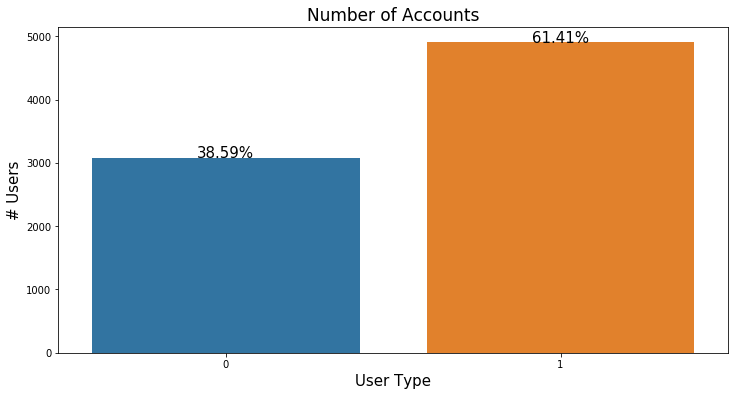

In [24]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = users)
g.set_title('Number of Accounts', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Users', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(users) * 100),
            ha="center", fontsize=15) 

In [25]:
# Unique accounts in Users table
len(users['id'].value_counts())

7989

In [26]:
# Unique accounts in Tweets table
len(tweets['user_id'].value_counts())

5995

__Observation__: It appears that there are more unique accounts in the Users table than the Tweets table. This might have been due to joining multiple accounts from various data collection sessions. 

## Merging Users and Tweets Table
Let's merge the Tweets table with the Users table to gain more insight on each tweet. We will also drop non-English tweets so that text preprocessing will be easier.  

In [27]:
users.rename(columns ={'id': 'user_id'}, inplace =True)
df_full = pd.merge(users, tweets,  how='inner', on=['user_id'] )

In [28]:
df_full.head()

,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at_y,timestamp_y,crawled_at_y,updated_y,class_y
0,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-26 18:56:00+00:00,2014-04-26 20:56:00,2014-11-13 01:44:20,2014-11-13 01:44:20,1
1,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-29 02:19:20+00:00,2014-04-29 04:19:20,2014-11-13 01:44:20,2014-11-13 01:44:20,1
2,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,1,2014-06-20 21:48:08+00:00,2014-06-20 23:48:08,2014-11-13 01:44:20,2014-11-13 01:44:20,1
3,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-29 02:18:48+00:00,2014-04-29 04:18:48,2014-11-13 01:44:20,2014-11-13 01:44:20,1
4,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-28 18:37:26+00:00,2014-04-28 20:37:26,2014-11-13 01:44:20,2014-11-13 01:44:20,1


In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5968328 entries, 0 to 5968327
Data columns (total 41 columns):
user_id                               int64
name                                  object
screen_name                           object
statuses_count                        int64
followers_count                       int64
friends_count                         int64
favourites_count                      int64
listed_count                          int64
lang                                  object
profile_image_url                     object
profile_use_background_image          int64
profile_background_image_url_https    object
profile_text_color                    object
profile_image_url_https               object
profile_sidebar_border_color          object
profile_sidebar_fill_color            object
profile_background_image_url          object
profile_background_color              object
profile_link_color                    object
created_at_x                          d

In [30]:
# Drop unwanted columns 
df_full = df_full.drop(columns=['id','crawled_at_y','updated_x', 'updated_y','class_y', 'crawled_at_x','profile_image_url',
                     'profile_use_background_image','profile_background_image_url_https','profile_text_color',
                     'profile_image_url_https','profile_sidebar_border_color','profile_sidebar_fill_color','profile_background_image_url',
                      'profile_background_color','profile_link_color','source','in_reply_to_status_id',
                     'in_reply_to_user_id','retweeted_status_id'])

In [31]:
df_full.rename(columns ={'created_at_x': 'u_created_at','created_at_y':'t_created_at','timestamp_x':'u_timestamp',
                    'timestamp_y':'t_timestamp','class_x':'class'}, inplace =True)

In [32]:
df_full.isnull().values.any()

False

In [33]:
len(df_full['user_id'].value_counts())

5874

In [34]:
df_full.shape

(5968328, 21)

In [35]:
# Collect only English tweets
df = df_full.loc[df_full['lang'] == 'en']

In [36]:
df.shape

(4338180, 21)

## Subsampling 

Due to hardware and memory limitations, we will reduce the size of the dataset and subsample 0.05% of tweets.

In [37]:
sub_tweets = df.groupby('class').apply(pd.DataFrame.sample, frac=0.005).reset_index(drop=True)

In [38]:
sub_tweets.shape

(21691, 21)

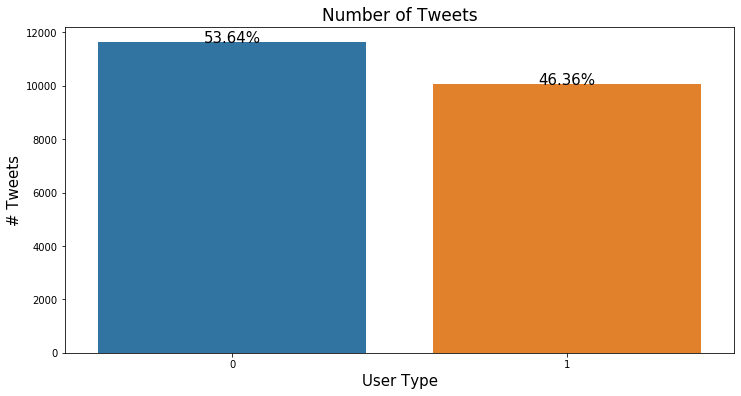

In [39]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = sub_tweets)
g.set_title('Number of Tweets', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Tweets', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(sub_tweets) * 100),
            ha="center", fontsize=15) 

__Observation__: After merging the tables together, we lost about 2 million tweets. Now, there are more genuine tweets than bot tweets. 

## Correlation
We'll start by exmaining the correlation between features and target varaible. 

In [40]:
# Find correlations with the target and sort
corr = sub_tweets.corr()['class'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 num_mentions       -0.426952
favourites_count   -0.341838
statuses_count     -0.247726
num_hashtags       -0.156566
listed_count       -0.089312
favorite_count     -0.067251
retweet_count      -0.051793
followers_count    -0.006343
user_id             0.128926
friends_count       0.137835
num_urls            0.218200
class               1.000000
reply_count              NaN
Name: class, dtype: float64

Most Negative Correlations:
 num_mentions       -0.426952
favourites_count   -0.341838
statuses_count     -0.247726
num_hashtags       -0.156566
listed_count       -0.089312
favorite_count     -0.067251
retweet_count      -0.051793
followers_count    -0.006343
user_id             0.128926
friends_count       0.137835
num_urls            0.218200
class               1.000000
reply_count              NaN
Name: class, dtype: float64


In [41]:
# Correlation 
top_feat = np.absolute(sub_tweets.corr()['class']).sort_values(ascending=False)[:11]
top_feat

class               1.000000
num_mentions        0.426952
favourites_count    0.341838
statuses_count      0.247726
num_urls            0.218200
num_hashtags        0.156566
friends_count       0.137835
user_id             0.128926
listed_count        0.089312
favorite_count      0.067251
retweet_count       0.051793
Name: class, dtype: float64

__Observation__: The correlation between our target variable and the top features are rather week. The strongest correlation to class is the num_mentions(-42%). This could possibly hint towards retweets and replying to other accounts to be a good indicator of whether a tweet was generated by a human or robot. 

In [42]:
# Top 10 features
print(top_feat.index)

Index(['class', 'num_mentions', 'favourites_count', 'statuses_count',
       'num_urls', 'num_hashtags', 'friends_count', 'user_id', 'listed_count',
       'favorite_count', 'retweet_count'],
      dtype='object')


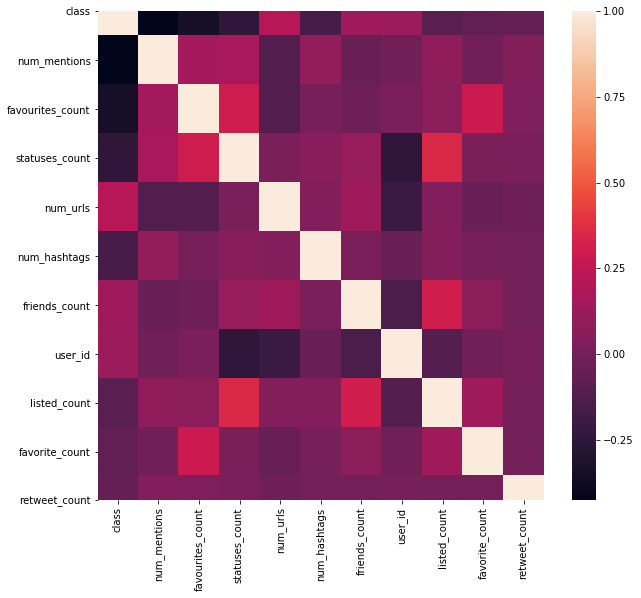

In [43]:
pp = sub_tweets[top_feat.index]
plt.figure(figsize=(10,9))
corr = pp.corr()
sns.heatmap(corr)
plt.savefig('heatmat.png')

__Observation__: There doesn't appear to be high collinearity among the features. 

## Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will use our findings to select a set of features for our model. 

For this assignment, we will take the following steps for feature selection:
 * creating User and Tweet based features
 * dropping unwanted variables
 * encode tweets

### Users based features
 * account_age_yr: age of account in present year 
 * digit_in_name: count of digits in screen name 
 * user_name_len: length of screen name

In [44]:
# Function to calculate the age of the account given creation time
def calculate_age(created_at):
    today = datetime.now()
    return today.year - created_at.year 

In [45]:
# Create new features 
sub_tweets['account_age_yr'] = sub_tweets['u_created_at'].apply(lambda x: calculate_age(x))
sub_tweets['digit_in_name'] = sub_tweets['screen_name'].apply(lambda x: sum(c.isdigit() for c in x))
sub_tweets['user_name_len'] = sub_tweets['screen_name'].apply(len)


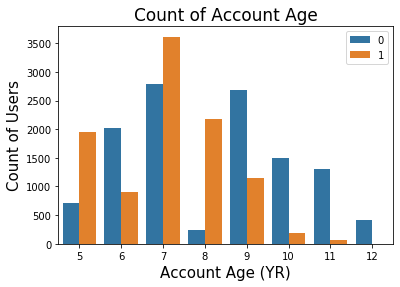

In [46]:
# Plot age of accounts 
g = sns.countplot(x='account_age_yr', hue= 'class',data=sub_tweets)
g.set_title('Count of Account Age', fontsize = 17)
g.set_xlabel('Account Age (YR)', fontsize = 15)
g.set_ylabel('Count of Users', fontsize = 15)
plt.legend(loc='upper right')

__Observation__: Most of the data was collected in 2012. 

### Tweets based features 
 * tweet_hour: hour of tweet post
 * tweet_month: month of tweet post
 * tweet_day: date of tweet post 
 * tweet_year: year of tweet post
 * tweet_length: length of tweet 
 * num_of_words: count of words in tweet

In [47]:
# Create new features 
sub_tweets['tweet_hour'] = sub_tweets['t_created_at'].apply(lambda x: x.hour)
sub_tweets['tweet_month'] = sub_tweets['t_created_at'].apply(lambda x: x.month)
sub_tweets['tweet_day'] = sub_tweets['t_created_at'].apply(lambda x: x.day)
sub_tweets['tweet_year'] = sub_tweets['t_created_at'].apply(lambda x: x.year)
sub_tweets['tweet_length'] = sub_tweets['text'].apply(len)
sub_tweets['num_of_words'] = sub_tweets['text'].str.split().apply(len)

In [48]:
sub_tweets.head()

,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,u_created_at,...,t_timestamp,account_age_yr,digit_in_name,user_name_len,tweet_hour,tweet_month,tweet_day,tweet_year,tweet_length,num_of_words
0,2273502326,maria,chrscolfrs,43671,5363,667,6682,88,en,2014-01-02 20:10:48+00:00,...,2015-02-18 05:44:39,5,0,10,4,2,18,2015,140,25
1,2329807592,d'Juanae •,mostH8tednae,25931,555,365,1600,2,en,2014-02-06 06:03:27+00:00,...,2015-03-18 09:10:48,5,1,12,8,3,18,2015,26,5
2,232165741,Cessy,princessnolasco,16872,539,438,807,3,en,2010-12-30 12:12:41+00:00,...,2014-07-20 13:49:54,9,0,15,11,7,20,2014,42,6
3,566099034,Stella Pantojan,stellapan2jan,1448,93,500,372,0,en,2012-04-29 05:45:54+00:00,...,2012-05-06 04:00:32,7,1,13,2,5,6,2012,79,10
4,520178852,Ivanncito ⚡️,ivannhoe_,29129,354,243,11995,1,en,2012-03-10 07:19:57+00:00,...,2014-10-27 08:12:23,7,0,9,7,10,27,2014,24,6


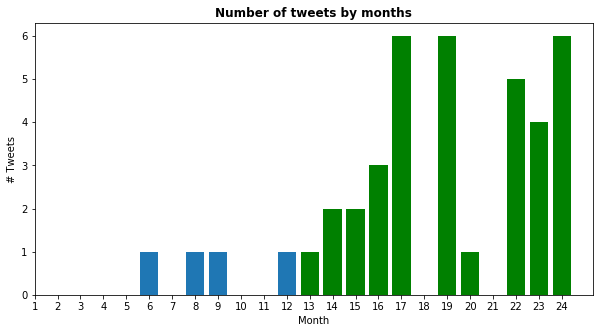

In [49]:
# Number of tweets by months

sub_tweets['t_month_year'] = sub_tweets['t_created_at'].apply(lambda x: str(x.year)+'-'+str(x.month)+'-1')
sub_tweets['t_month_year'].unique()[0]
sub_tweets['t_month_year'] = pd.to_datetime(sub_tweets['t_month_year'])

sub_tweets[['t_created_at', 't_month_year']].head()

yr_monthly_tweets2 = sub_tweets.groupby(['tweet_month','tweet_year']).size().unstack()


plt.figure(figsize=(10,5))

plt.title('Number of tweets by months', fontsize=12, fontweight='bold')
plt.bar(yr_monthly_tweets2.index, yr_monthly_tweets2.values[:,0])
plt.bar(yr_monthly_tweets2.index+12, yr_monthly_tweets2.values[:,1], color='g')
plt.xticks(list(yr_monthly_tweets2.index)+list(yr_monthly_tweets2.index+12))
plt.xlabel('Month')
plt.ylabel('# Tweets')
plt.show() 

In [50]:
sub_tweets['t_month_year'].describe()

count                   21691
unique                     79
top       2014-10-01 00:00:00
freq                     4526
first     2008-06-01 00:00:00
last      2015-05-01 00:00:00
Name: t_month_year, dtype: object

In [51]:
sub_tweets['tweet_year'].describe()

count    21691.000000
mean      2014.113688
std          0.747445
min       2008.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: tweet_year, dtype: float64

In [52]:
sub_tweets.shape

(21691, 31)

__Observation__: This dataset contains tweets posted from 2007 to 2015. Majority of the tweets were collected during 2014 and 2015. 

In [53]:
sub_tweets.columns

Index(['user_id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'lang',
       'u_created_at', 'u_timestamp', 'class', 'text', 'retweet_count',
       'reply_count', 'favorite_count', 'num_hashtags', 'num_urls',
       'num_mentions', 't_created_at', 't_timestamp', 'account_age_yr',
       'digit_in_name', 'user_name_len', 'tweet_hour', 'tweet_month',
       'tweet_day', 'tweet_year', 'tweet_length', 'num_of_words',
       't_month_year'],
      dtype='object')

## Text Processing: Clean and Transform Tweets

Before we can have a model process information from the tweets, we must convert text to numeric values that machines can understand. 

We will clean the tweets with the following steps:
1. Clean tweets by removing hyperlinks, mentions, and 'RT' from retweets
2. Word Counts with __CountVectorizer__: Convert a collection of text documents to a matrix of token counts
     - Tokenization: Converting a sentence into a list of words
     - Remove stop words: Terms that will be ignored because they either
         - occurred in too many documents (max_df)
         - occurred in too few documents (min_df)
         - were cut off by feature selection (max_features).
     - Lemmatization/stemming: Converting any form of a word to its root word
     - Returns vectors of the counts of each word
     
3. Word Frequencies with __TfidfTransform__: Transform a count matrix to a normalized tf representation
     - Term Frequency: This summarizes how often a given word appears within a document
     - Inverse Document Frequency: This downscales words that appear a lot across documents <br>
     - Returns a spare matrix with rows of terms and columns of documents
    

Reference:
[clean tweet](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

 

### Clean Tweets
First, we will partition tweets into separate classes for building bag of words and cut down on processing time for CountVectorizer and TfidTransformer. 
 
Let's start by cleaning the bot tweets.

In [54]:
sub_tweets['text'] = sub_tweets['text'].astype('str')

In [55]:
# Create df for user class
bots = sub_tweets.loc[sub_tweets['class']==1]
gen = sub_tweets.loc[sub_tweets['class']==0]

In [56]:
# Create new df 
b_tweets = pd.DataFrame(bots['text'])
b_tweets.head()

,text
11636,The key to being a good manager is keeping the...
11637,Non insultare mai un alligatore prima di avere...
11638,"Goonies never say die. - Mike, The Goonies"
11639,"Your goals, minus your doubts, equal your real..."
11640,Dulce embustera la maldita primavera..* #ToyEn...


In [57]:
# Create new df  
g_tweets = pd.DataFrame(gen['text'])
g_tweets.head()

,text
0,RT @lauradreyfuss: Yesterday I had cheese frie...
1,RT @TaeFromDa1: I'm Mean ?
2,Happy birthday @solennheussaff Bite me! xx
3,RT @peoplemag: Amanda Bynes Involved in Anothe...
4,Just hit fire on Yik Yak


Let's clean the tweets to remove links, @, and RT.

In [58]:
def link_cleaner(text):
    text = re.sub(r'http.*','',text)
    text = re.sub("@[A-Za-z0-9]+",'',text)
    text = re.sub(r'bit/ly.*', '', text)
    text = re.sub(r'b\'', '', text)
    text = re.sub(r'b"', '', text)
    text = text.replace('RT', '')
    return text

b_tweets['clean_tweets'] = b_tweets['text'].apply(lambda x: link_cleaner(x))

b_tweets.head()

,text,clean_tweets
11636,The key to being a good manager is keeping the...,The key to being a good manager is keeping the...
11637,Non insultare mai un alligatore prima di avere...,Non insultare mai un alligatore prima di avere...
11638,"Goonies never say die. - Mike, The Goonies","Goonies never say die. - Mike, The Goonies"
11639,"Your goals, minus your doubts, equal your real...","Your goals, minus your doubts, equal your real..."
11640,Dulce embustera la maldita primavera..* #ToyEn...,Dulce embustera la maldita primavera..* #ToyEn...


In [59]:
g_tweets['clean_tweets'] = g_tweets['text'].apply(lambda x: link_cleaner(x))

g_tweets.head()

,text,clean_tweets
0,RT @lauradreyfuss: Yesterday I had cheese frie...,": Yesterday I had cheese fries for lunch, che..."
1,RT @TaeFromDa1: I'm Mean ?,: I'm Mean ?
2,Happy birthday @solennheussaff Bite me! xx,Happy birthday Bite me! xx
3,RT @peoplemag: Amanda Bynes Involved in Anothe...,: Amanda Bynes Involved in Another Car Mishap
4,Just hit fire on Yik Yak,Just hit fire on Yik Yak


In [60]:
# Return only characters 
def clean_alpha(text):
    text = " ".join(re.split("[^a-zA-Z]*", text))
    return text

b_tweets['clean_tweets'] = b_tweets['clean_tweets'].apply(lambda x: clean_alpha(x.lower()))

b_tweets.head()

/Users/tsawaengsri/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


,text,clean_tweets
11636,The key to being a good manager is keeping the...,the key to being a good manager is keeping the...
11637,Non insultare mai un alligatore prima di avere...,non insultare mai un alligatore prima di avere...
11638,"Goonies never say die. - Mike, The Goonies",goonies never say die mike the goonies
11639,"Your goals, minus your doubts, equal your real...",your goals minus your doubts equal your realit...
11640,Dulce embustera la maldita primavera..* #ToyEn...,dulce embustera la maldita primavera toyensalsa


In [61]:
g_tweets['clean_tweets'] = g_tweets['clean_tweets'].apply(lambda x: clean_alpha(x.lower()))

g_tweets.head()

,text,clean_tweets
0,RT @lauradreyfuss: Yesterday I had cheese frie...,yesterday i had cheese fries for lunch cheese...
1,RT @TaeFromDa1: I'm Mean ?,i m mean
2,Happy birthday @solennheussaff Bite me! xx,happy birthday bite me xx
3,RT @peoplemag: Amanda Bynes Involved in Anothe...,amanda bynes involved in another car mishap
4,Just hit fire on Yik Yak,just hit fire on yik yak


In [62]:
# Define stopwords to exclude
stop = set(stopwords.words('english'))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

In [63]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tsawaengsri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
# Import the lemmatizer from nltk
lemma = WordNetLemmatizer()

# Define word cleaning function
def final_clean(text, stop=stop):
    text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

b_tweets['clean_tweets'] = b_tweets['clean_tweets'].apply(lambda x: final_clean(x))

b_tweets.head()

,text,clean_tweets
11636,The key to being a good manager is keeping the...,key good manager keeping people hate away stil...
11637,Non insultare mai un alligatore prima di avere...,non insultare mai un alligatore prima di avere...
11638,"Goonies never say die. - Mike, The Goonies",goony never say die mike goony
11639,"Your goals, minus your doubts, equal your real...",goal minus doubt equal reality ralph marston
11640,Dulce embustera la maldita primavera..* #ToyEn...,dulce embustera la maldita primavera toyensalsa


In [65]:
g_tweets['clean_tweets'] = g_tweets['clean_tweets'].apply(lambda x: final_clean(x))

g_tweets.head()

,text,clean_tweets
0,RT @lauradreyfuss: Yesterday I had cheese frie...,yesterday cheese fry lunch cheese fry dinner d...
1,RT @TaeFromDa1: I'm Mean ?,mean
2,Happy birthday @solennheussaff Bite me! xx,happy birthday bite xx
3,RT @peoplemag: Amanda Bynes Involved in Anothe...,amanda bynes involved another car mishap
4,Just hit fire on Yik Yak,hit fire yik yak


Since we were unable to translate non English tweets, those cells are empty and will be dropped.

In [66]:
# Add clean_tweets back to bots and gen df to drop empty tweets
bots['clean_tweets'] = b_tweets['clean_tweets']
gen['clean_tweets'] = g_tweets['clean_tweets']

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
# Shape before dropping empty tweets
print(bots.shape)
print(gen.shape)

(10055, 32)
(11636, 32)


In [68]:
# Replace field that's entirely space (or empty) with NaN
bots = bots.replace(r'^\s*$', np.nan, regex=True)
gen = gen.replace(r'^\s*$', np.nan, regex=True)

In [69]:
# Drop nan
bots = bots.dropna() 
gen = gen.dropna()

In [70]:
# Reset index to start at 0
bots = bots.reset_index()
gen = gen.reset_index() 

In [71]:
# Shape after dropping empty tweets
print(bots.shape)
print(gen.shape)

(9956, 33)
(11137, 33)


__Observation__: We lost 99 bots tweets and 499 genuine tweets. 

In [72]:
# Convert df to np arrary 
b_clean = bots['clean_tweets'].values
g_clean = gen['clean_tweets'].values

In [73]:
# Convert np arrary to one deminsional array 
b_clean = b_clean.ravel()

In [74]:
type(b_clean)

numpy.ndarray

In [75]:
# Convert np arrary to one deminsional array 
g_clean = g_clean.ravel()

In [76]:
type(g_clean)

numpy.ndarray

### Count Vectorizer
Converting a collection of stemmed tweets to a matrix of token counts

In [77]:
# Initialize a CountVectorizer object for bot tweets
b_count_vectorizer = CountVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return term-document matrix for bot tweets
b_clean = b_count_vectorizer.fit_transform(b_clean) 

# Summarize encoded vector
print(b_clean.shape)
print(type(b_clean))

(9956, 11448)
<class 'scipy.sparse.csr.csr_matrix'>


In [78]:
# Bot Tweets Vocabulary 
b_vocab = b_count_vectorizer.get_feature_names()
np.array(b_vocab[:30])

array(['aa', 'aaaa', 'aac', 'aacec', 'aahahhaha', 'aaron', 'ab', 'aba',
       'abba', 'abbandonano', 'abbandonata', 'abbandonato', 'abbastanza',
       'abbatte', 'abbestia', 'abbey', 'abbi', 'abbia', 'abbiamo',
       'abbondio', 'abbracciai', 'abbraccio', 'abbreviata', 'abdul',
       'abel', 'abides', 'abilit', 'ability', 'abiti', 'abitua'],
      dtype='<U11')

In [79]:
# Initialize a CountVectorizer object for bot tweets
g_count_vectorizer = CountVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return term-document matrix for genuine tweets
g_clean = g_count_vectorizer.fit_transform(g_clean)

# Summarize encoded vector
print(g_clean.shape)
print(type(g_clean))

(11137, 16864)
<class 'scipy.sparse.csr.csr_matrix'>


In [80]:
# Genuine Tweets Vocabulary 
g_vocab = g_count_vectorizer.get_feature_names()
np.array(g_vocab[:30])

array(['aa', 'aaa', 'aaaaaaaa', 'aaaaaaaah', 'aaaaaaw', 'aaaaaay',
       'aaall', 'aaani', 'aadhar', 'aah', 'aaj', 'aalame', 'aaliyah',
       'aaliyahmovie', 'aaliyahprincessofrnb', 'aan', 'aane', 'aap',
       'aapbreakup', 'aaral', 'aarkeep', 'aaron', 'aaronhernandez',
       'aata', 'ab', 'aba', 'abad', 'abaita', 'abandoned', 'abandonment'],
      dtype='<U20')

### Tfidf Transformer 
"The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus".[Source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

In [81]:
# Learn the idf vector (global term weights) for bot tweets
b_tf_transformer = TfidfTransformer(use_idf=False).fit(b_clean) # Don't enable inverse-document-frequency reweighting

# Transform a count matrix to a tf-idf representation
b_tfidf_train = b_tf_transformer.transform(b_clean)

# Summarize encoded vector
print(b_tfidf_train.shape)
print(type(b_tfidf_train))

(9956, 11448)
<class 'scipy.sparse.csr.csr_matrix'>


In [82]:
# Learn the idf vector (global term weights) for genuine tweets
g_tf_transformer = TfidfTransformer(use_idf=False).fit(g_clean)

# Transform a count matrix to a tf-idf representation
g_tfidf_train = g_tf_transformer.transform(g_clean)

# Summarize encoded vector
print(g_tfidf_train.shape)
print(type(g_tfidf_train))

(11137, 16864)
<class 'scipy.sparse.csr.csr_matrix'>


As shown above, there are over 10,000 tokens for both bots and genuine tweets. We'll need to reduce the number of features to prevent overfitting. 

### TruncatedSVD
"This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently." [Source](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [83]:
# TruncatedSVD to reduce dimensions 
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42).fit(b_tfidf_train)
b_svdTFit = svd.fit_transform(b_tfidf_train)

# Summary of transformation 
print(b_svdTFit.shape)
print(svd.explained_variance_)
print(svd.explained_variance_ratio_.sum())

(9956, 100)
[0.02317442 0.01646229 0.0106973  0.00811188 0.00642986 0.0071409
 0.00568624 0.00590966 0.00556653 0.00514696 0.00480164 0.00467423
 0.00465834 0.00451091 0.00424423 0.00414758 0.00401772 0.00381073
 0.00386141 0.00373272 0.00360812 0.00351939 0.00337693 0.00327084
 0.00328442 0.0031961  0.00319243 0.00306285 0.00304528 0.00300808
 0.00293666 0.00293644 0.00288142 0.00277216 0.00273574 0.00268754
 0.00263727 0.00259042 0.00254506 0.00247434 0.00242199 0.00240915
 0.00236664 0.00234333 0.00231304 0.00227434 0.00223528 0.00220354
 0.00216825 0.00216474 0.00215777 0.0021329  0.00211771 0.0020616
 0.00202088 0.00200545 0.00200486 0.00197281 0.00197249 0.00196277
 0.00194067 0.0019038  0.00188238 0.00184494 0.00179758 0.00179758
 0.00177779 0.00175308 0.00174797 0.00174458 0.00173747 0.00171757
 0.00170183 0.00169209 0.00166921 0.0016634  0.00165344 0.0016475
 0.00164422 0.00163155 0.00161307 0.00159167 0.00158868 0.00156938
 0.00156329 0.00153872 0.00152058 0.00151632 0.001508

In [84]:
# TruncatedSVD to reduce dimensions 
svd2 = TruncatedSVD(n_components=100, n_iter=7, random_state=42).fit(g_tfidf_train)
g_svdTFit = svd2.fit_transform(g_tfidf_train)

# Summary of transformation 
print(g_svdTFit.shape)
print(svd2.explained_variance_)
print(svd2.explained_variance_ratio_.sum())

(11137, 100)
[0.00727238 0.00764755 0.00546759 0.00527642 0.00491343 0.00475251
 0.00454533 0.00414211 0.00383692 0.00376934 0.00365418 0.00339461
 0.00335548 0.00322068 0.00321645 0.00313297 0.00314836 0.00309614
 0.0030687  0.00302401 0.00292878 0.00288966 0.00281478 0.00277297
 0.0027174  0.00266123 0.00248437 0.00251509 0.00248401 0.00245919
 0.00242841 0.00236869 0.00234353 0.00233959 0.00230877 0.00227567
 0.00225065 0.00220802 0.00216152 0.00213192 0.00210539 0.00202826
 0.00201219 0.00201034 0.00196301 0.00192655 0.00191408 0.00188545
 0.0018636  0.00183568 0.00181599 0.00178906 0.00175471 0.00170324
 0.00168114 0.00164396 0.0016292  0.00162017 0.0015934  0.0015794
 0.00156761 0.00153973 0.0015331  0.00151694 0.00150692 0.00148978
 0.00148257 0.00147313 0.00145956 0.00143742 0.0014199  0.00141159
 0.0013988  0.00138635 0.00138842 0.00136495 0.0013628  0.00134898
 0.00134891 0.00132883 0.00132141 0.00131832 0.00129689 0.00129534
 0.00127115 0.00125365 0.00123927 0.00123747 0.001

In [85]:
# Convert svdTFit array to df 
b_svdTFit = pd.DataFrame(b_svdTFit)
b_svdTFit.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.001529,0.004748,0.016719,-0.015954,0.062592,-0.015292,0.082976,-0.036031,0.001840,-0.031003,...,-0.026602,-0.052495,-0.005248,0.031259,0.002269,0.024469,0.008212,-0.021738,-0.005896,0.018119
1,0.000256,0.000142,0.000904,-0.002135,0.005002,-0.004668,0.028631,0.071881,0.314855,0.004492,...,-0.006412,0.002743,-0.008935,0.005370,0.002193,0.002589,-0.004489,-0.023543,0.004544,-0.009689
2,0.000776,0.000503,0.002053,-0.002202,0.006565,-0.004897,0.012119,-0.004145,0.000028,0.008726,...,0.045981,-0.065590,0.071539,0.038472,-0.062263,-0.023763,-0.015930,-0.066150,0.043810,0.009818
3,0.000287,0.000636,0.001709,-0.001395,0.004864,-0.003272,0.008812,-0.001448,0.000108,-0.005223,...,-0.020337,0.022783,-0.021963,-0.014923,0.016777,0.021479,-0.007959,-0.010295,0.017018,0.000650
4,0.003273,0.000308,0.001138,-0.002154,0.002317,-0.002837,0.015588,0.043891,0.174545,0.002881,...,0.003579,0.003235,-0.007627,0.000249,-0.001239,-0.001698,0.005678,0.002147,0.006102,0.003425


In [86]:
print(b_svdTFit.shape)

(9956, 100)


In [87]:
bots.shape

(9956, 33)

In [88]:
# Convert svdTFit array to df 
g_svdTFit = pd.DataFrame(g_svdTFit)
g_svdTFit.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.012888,0.001854,0.024016,-0.024221,-0.021909,0.000993,-0.002009,-0.005099,0.000510,-0.004162,...,0.005330,0.010747,-0.011286,-0.007316,0.009067,0.012600,0.014240,0.004468,-0.005797,0.006875
1,0.009938,0.004197,0.016362,0.000700,0.014640,0.013355,-0.010915,0.022792,0.016824,0.025654,...,-0.096038,-0.003199,0.006557,0.010790,-0.032239,-0.017420,-0.031453,-0.087720,0.043023,0.015751
2,0.033155,0.024667,0.071282,0.062571,-0.005090,-0.019585,-0.008260,0.002306,0.049460,-0.026532,...,0.011089,0.015564,-0.000724,-0.011644,0.005250,0.002076,-0.026697,-0.023342,0.011945,0.002477
3,0.003154,-0.000327,0.003591,-0.000445,0.003074,0.001987,-0.001852,0.002285,0.004678,-0.002937,...,0.003732,-0.008327,-0.000860,-0.004994,-0.002800,0.004686,-0.006349,0.002406,0.011561,0.001218
4,0.007287,-0.001360,0.002460,-0.000255,0.003001,0.000356,0.001161,-0.000075,0.000310,-0.002611,...,-0.022266,-0.012283,0.022133,0.006000,0.043344,0.012203,-0.042710,-0.015227,-0.001509,0.021852


In [89]:
g_svdTFit.shape

(11137, 100)

In [90]:
gen.shape

(11137, 33)

In [91]:
# Place the DataFrames side by side
bots_tfid = pd.concat([bots, b_svdTFit], axis=1)
bots_tfid.head()

,index,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,...,90,91,92,93,94,95,96,97,98,99
0,11636,157884661,Kayak iGuide,kayakiguide,11106,668,1287,1,2,en,...,-0.026602,-0.052495,-0.005248,0.031259,0.002269,0.024469,0.008212,-0.021738,-0.005896,0.018119
1,11637,1273187820,Flavius,FlavioMarcelli,1505,717,1069,0,1,en,...,-0.006412,0.002743,-0.008935,0.005370,0.002193,0.002589,-0.004489,-0.023543,0.004544,-0.009689
2,11638,934684128,Giggly Stuff,gigglystuff,9770,21460,2574,0,0,en,...,0.045981,-0.065590,0.071539,0.038472,-0.062263,-0.023763,-0.015930,-0.066150,0.043810,0.009818
3,11639,164303126,Juan De La Torre,juantorre55,12732,1149,932,1,16,en,...,-0.020337,0.022783,-0.021963,-0.014923,0.016777,0.021479,-0.007959,-0.010295,0.017018,0.000650
4,11640,57007623,Rafiela Morales L.,RafielaMorales,7975,398,350,11,2,en,...,0.003579,0.003235,-0.007627,0.000249,-0.001239,-0.001698,0.005678,0.002147,0.006102,0.003425


In [92]:
bots_tfid.shape

(9956, 133)

In [93]:
# Join Tfid with class df 
gen_tfid = pd.concat([gen, g_svdTFit], axis =1)
gen_tfid.head()

,index,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,...,90,91,92,93,94,95,96,97,98,99
0,0,2273502326,maria,chrscolfrs,43671,5363,667,6682,88,en,...,0.005330,0.010747,-0.011286,-0.007316,0.009067,0.012600,0.014240,0.004468,-0.005797,0.006875
1,1,2329807592,d'Juanae •,mostH8tednae,25931,555,365,1600,2,en,...,-0.096038,-0.003199,0.006557,0.010790,-0.032239,-0.017420,-0.031453,-0.087720,0.043023,0.015751
2,2,232165741,Cessy,princessnolasco,16872,539,438,807,3,en,...,0.011089,0.015564,-0.000724,-0.011644,0.005250,0.002076,-0.026697,-0.023342,0.011945,0.002477
3,3,566099034,Stella Pantojan,stellapan2jan,1448,93,500,372,0,en,...,0.003732,-0.008327,-0.000860,-0.004994,-0.002800,0.004686,-0.006349,0.002406,0.011561,0.001218
4,4,520178852,Ivanncito ⚡️,ivannhoe_,29129,354,243,11995,1,en,...,-0.022266,-0.012283,0.022133,0.006000,0.043344,0.012203,-0.042710,-0.015227,-0.001509,0.021852


In [94]:
gen_tfid.shape

(11137, 133)

In [95]:
# Concatenate bots_tfid and gen_tfid to create df for modeling 
df_clean = pd.concat([bots_tfid, gen_tfid], ignore_index=True)

df_clean.head()

,index,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,...,90,91,92,93,94,95,96,97,98,99
0,11636,157884661,Kayak iGuide,kayakiguide,11106,668,1287,1,2,en,...,-0.026602,-0.052495,-0.005248,0.031259,0.002269,0.024469,0.008212,-0.021738,-0.005896,0.018119
1,11637,1273187820,Flavius,FlavioMarcelli,1505,717,1069,0,1,en,...,-0.006412,0.002743,-0.008935,0.005370,0.002193,0.002589,-0.004489,-0.023543,0.004544,-0.009689
2,11638,934684128,Giggly Stuff,gigglystuff,9770,21460,2574,0,0,en,...,0.045981,-0.065590,0.071539,0.038472,-0.062263,-0.023763,-0.015930,-0.066150,0.043810,0.009818
3,11639,164303126,Juan De La Torre,juantorre55,12732,1149,932,1,16,en,...,-0.020337,0.022783,-0.021963,-0.014923,0.016777,0.021479,-0.007959,-0.010295,0.017018,0.000650
4,11640,57007623,Rafiela Morales L.,RafielaMorales,7975,398,350,11,2,en,...,0.003579,0.003235,-0.007627,0.000249,-0.001239,-0.001698,0.005678,0.002147,0.006102,0.003425


In [96]:
df_clean.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21093 entries, 0 to 21092
Data columns (total 133 columns):
index               int64
user_id             int64
name                object
screen_name         object
statuses_count      int64
followers_count     int64
friends_count       int64
favourites_count    int64
listed_count        int64
lang                object
u_created_at        datetime64[ns, UTC]
u_timestamp         datetime64[ns]
class               int64
text                object
retweet_count       int64
reply_count         int64
favorite_count      int64
num_hashtags        int64
num_urls            int64
num_mentions        int64
t_created_at        datetime64[ns, UTC]
t_timestamp         datetime64[ns]
account_age_yr      int64
digit_in_name       int64
user_name_len       int64
tweet_hour          int64
tweet_month         int64
tweet_day           int64
tweet_year          int64
tweet_length        int64
num_of_words        int64
t_month_year        datetime64[ns]

In [97]:
# Drop unwanted columns 
df_clean = df_clean.drop(columns=['index','user_id','name','screen_name','lang','text','t_created_at','t_timestamp','u_created_at', 'u_timestamp', 't_month_year', 
                                    'clean_tweets'])

In [98]:
df_clean.shape

(21093, 121)

In [99]:
# Check for null values 
df_clean.isnull().sum().sum()

0

# Supervised Learning: Building a Bot Classifer 
In this section we will build, train, and evaluate several machine learning methods to classify tweets.

### Split Train and Test set¶
Let's split dataset by using function train_test_split(). Here, the Dataset is broken into two parts in a ratio of 70:30. It means 70% data will be used for model training and 30% for model testing.

To continue feature selection, we will start by using the original attributes in the raw training set.

In [100]:
# Set variables 
y = df_clean['class']
X = df_clean.drop(columns=['class'])

In [101]:
print(np.any(np.isnan(X)))

False


In [102]:
print(np.all(np.isfinite(X)))

True


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Metric 
We will evaluate our models based on their predicted probability __ROC AUC score__. ROC AUC "summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds"[Brownlee](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

We’ll also focus on the __false positive rate__(FPR) and __false negative rate__(FNR). False positive rate is identifying genuine tweets as robot tweets. This could lead to disregarding value customer behavior information, which can provide misleading data for future marketing campaigns and lower customer satisfaction. False negative rate is failure to label true robot tweets as bots tweets, which results in obtaining false customer information. 

FPR and FNR are reflected in the following metrics: 

 * __Accuracy__: ratio of properly labeled accounts 

 * __Precision__: ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answers is of all tweets that are labeled as bots, how many are actually bots? High precision relates to the low false positive rate. 

 * __Recall (Sensitivity)__: ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answer is: Of all the tweets that were generated by bots, how many did we label?


### Model Selection

We will compare three different machine-learning models:

__Logistic Regression__
 * Serve as a baseline model since our task is binary 
 * Assumes features are independent and captures linear relationships 
 * Not able to capture non-linear relationships may result in poor performance

__Random Forest Classifier__
 * Ensemble model which aggregates several decision trees to reduce effects of noise 
 * Handles higher dimensionality well and provides importance of variables for feature selection 
 * Will tune parameters by selecting number of trees/estimators 

__Multiple-Perceptron-Classifier__
 * Deep Learning model that trains using back propagation 
 * Able to capture non-linear models
 * Will tune parameters by selecting features like hidden layers

We will adjust the steps of data preprocessing for each model to get most out.

### Logistic Regression 
First, we'll create and train the model to make predictions on the testing data.

In [104]:
# Function to plot ROC curve 
def roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred_proba2 = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba)
    fpr2, tpr2, thresholds = metrics.roc_curve(y_test, y_pred_proba2)

    model_auc = metrics.roc_auc_score(y_train, y_pred_proba)
    model_auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="Train, auc="+str(round(model_auc,4)))
    ax.plot(fpr2, tpr2, label="Test, auc="+str(round(model_auc2,4)))

    plt.title('ROC curve')
    ax.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [105]:
# Logistic Regression Model 
lr = LogisticRegression()

# Fit and predict 
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

# CV to check if overfitting 
print(cross_val_score(lr, X_train, y_train, cv=10, scoring='roc_auc'))

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solv

[0.98257735 0.98584225 0.98364419 0.98704889 0.98252584 0.97938785
 0.98275941 0.98608192 0.9813468  0.98726078]


In [106]:
# Calculate metrics
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (lr_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (lr_accuracy * 100.0))
print('Recall: %.2f%%' % (lr_recall * 100.0))
print('Precision: %.2f%%' % (lr_precision * 100.0))
print(confusion_matrix(y_test, lr_y_pred))

ROC_AUC: 95.24%
Accuracy: 95.13%
Recall: 97.12%
Precision: 92.89%
[[3119  222]
 [  86 2901]]


#### Optimized Logistic Regression Model 
Now, we will perform hyperparameter tuning and use GridSearch Cross Validation to find the best parameters for optimal performance.

* __penalty__: penalize large coefficients to avoid overfitting 
 - 'l1' sum of the absolute values of the coefficients
 - 'l2' the sum of the squared of the coefficients
* __C__: Inverse of regularization strength; values specify stronger regularization
* __max_iter__: Maximum number of iterations taken for the solvers to converge

In [107]:
# Logistic Model
start_time = time.time()

parameters = {}
parameters['penalty'] = ['l1','l2']
parameters['C'] = [1.0,2.0]
parameters['max_iter'] = [100,120,140]

lr = LogisticRegression()
gsc_lr = GridSearchCV(lr, parameters, cv=10, scoring='roc_auc')
gsc_lr.fit(X_train, y_train)
print("Best: %f using %s" %(gsc_lr.best_score_,gsc_lr.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' seconds')

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solv

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

Best: 0.986518 using {'C': 1.0, 'max_iter': 120, 'penalty': 'l1'}
Execution time: 337.30635809898376 seconds


In [108]:
# Optimized Logistic Regression Model 
gsc_lr = LogisticRegression(penalty='l1', C=1.0, max_iter=120)
gsc_lr.fit(X_train, y_train)
gsc_lr_y_pred = gsc_lr.predict(X_test)

# CV to check if overfitting 
print(cross_val_score(gsc_lr, X_train, y_train, cv=10, scoring='roc_auc'))

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

[0.98704153 0.98840636 0.98488393 0.9895339  0.98564176 0.98132289
 0.9865884  0.98498609 0.98547046 0.99120409]


In [109]:
# Calculate metrics
gsc_lr_roc_auc = roc_auc_score(y_test, gsc_lr_y_pred)
gsc_lr_accuracy = accuracy_score(y_test, gsc_lr_y_pred)
gsc_lr_recall = recall_score(y_test, gsc_lr_y_pred)
gsc_lr_precision = precision_score(y_test, gsc_lr_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_lr_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_lr_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_lr_recall * 100.0))
print('Precision: %.2f%%' % (gsc_lr_precision * 100.0))
print(confusion_matrix(y_test, gsc_lr_y_pred))

ROC_AUC: 95.84%
Accuracy: 95.78%
Recall: 96.85%
Precision: 94.36%
[[3168  173]
 [  94 2893]]


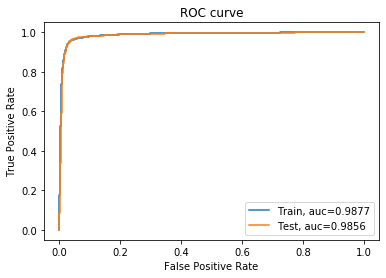

In [110]:
# Function to plot ROC curve 
roc_curve(gsc_lr, X_train, y_train, X_test, y_test)

__Evaluation__: From cross validation, this model doesn't seem to be overfitting by much since the roc auc scores range between 0.97 to 0.98. It doesn't seem like hyperparameter tuning made much of an improvement since the roc auc and accuracy score on the test set remained as 95%. Even though there were more genuine tweets, this model was better at identifying tweets from bots based on a higher recall score(96%) than the precision score (94%).

### Random Forest 
Let's try a more complex model to see if random forest can capture the complexity within the dataset. 

In [111]:
# Random Forest Model 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit and predict
rf.fit(X_train, y_train) 
rf_y_pred = rf.predict(X_test)

# Check if model is overfitting 
print(cross_val_score(rf, X_train, y_train, cv=10, scoring='roc_auc'))

[0.99997793 0.99996505 0.99998161 0.99997333 0.99966063 0.99998161
 0.99998158 1.         0.99980938 0.99999262]


In [112]:
# Calculate metrics
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (rf_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))
print('Recall: %.2f%%' % (rf_recall * 100.0))
print('Precision: %.2f%%' % (rf_precision * 100.0))
print(confusion_matrix(y_test, rf_y_pred))


ROC_AUC: 99.58%
Accuracy: 99.60%
Recall: 99.16%
Precision: 100.00%
[[3341    0]
 [  25 2962]]


#### Optmized Random Forest
Now, we'll find the optimal parameters by GridSearchCV.

* __n_estimators__: number of trees you want to build before taking the maximum voting or averages of predictions
* __criterion__: function to measure the quality of a split
* __max_features__: number of features to consider when looking for the best split

In [113]:
#Optimizing Random Forest
start_time = time.time()

parameters = {}
parameters['n_estimators'] = [100,300,400]
parameters['criterion'] = ['entropy','gini']
parameters['max_features'] = ['sqrt','log2']


gsc_rf = GridSearchCV(rf, parameters, cv=10, verbose=1, scoring='roc_auc')
gsc_rf.fit(X_train, y_train)
print("Best: %f using %s" %(gsc_rf.best_score_,gsc_rf.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' seconds')

# Best: 0.999875 using {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
#Execution time: 2389.9600927829742 seconds

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 44.5min finished


Best: 0.999970 using {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 400}
Execution time: 2710.740029811859 seconds


In [114]:
# Optimized Random Forest
gsc_rf = RandomForestClassifier(n_estimators=400, criterion='entropy', max_features='sqrt', random_state=42)
gsc_rf.fit(X_train, y_train) 
gsc_rf_y_pred = gsc_rf.predict(X_test)

# Check if model is overfitting 
print(cross_val_score(gsc_rf, X_train, y_train, cv=10, scoring='roc_auc'))

[0.99997977 0.99998528 0.99998896 0.99996873 0.99991723 0.99997977
 0.99996777 1.         0.9999116  1.        ]


In [115]:
# Calculate metrics
gsc_rf_roc_auc = roc_auc_score(y_test, gsc_rf_y_pred)
gsc_rf_accuracy = accuracy_score(y_test, gsc_rf_y_pred)
gsc_rf_recall = recall_score(y_test, gsc_rf_y_pred)
gsc_rf_precision = precision_score(y_test, gsc_rf_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_rf_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_rf_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_rf_recall * 100.0))
print('Precision: %.2f%%' % (gsc_rf_precision * 100.0))
print(confusion_matrix(y_test, gsc_rf_y_pred))

ROC_AUC: 99.55%
Accuracy: 99.57%
Recall: 99.10%
Precision: 100.00%
[[3341    0]
 [  27 2960]]


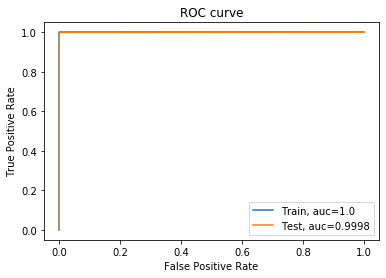

In [116]:
# Function to plot ROC curve 
roc_curve(gsc_rf, X_train, y_train, X_test, y_test)

__Evaluation__: The random forest model out performs the logistic regression model across all metrics. This model was better at labeling genuine tweets than bot tweets. This could possibly be due to the clean dataset containing 1,211 more genuine tweets than bot tweets. Based on the recall and precision scores, hyperparameter tuning did not improve the performance of the model.

### Model Interpretation: Feature Importance
For model interpretability, we will take a look at the feature importance of our optimized random forest. We may use these feature importance as a method of dimensionality reduction in future work.

In [117]:
# Top N importances
N = 10
importances = gsc_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in gsc_rf.estimators_],
             axis=0)

# Create a dataframe
importances_df = pd.DataFrame({'Variable':X.columns, 'Importance': importances})

top_N = importances_df.sort_values(by=['Importance'], ascending=False).head(10)

top_N

,Variable,Importance
3,favourites_count,0.283297
17,tweet_year,0.063495
26,6,0.061685
0,statuses_count,0.050247
2,friends_count,0.042590
15,tweet_month,0.041075
20,0,0.038992
25,5,0.035890
10,num_mentions,0.034861
70,50,0.032996


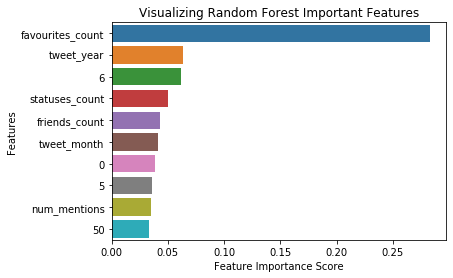

In [118]:
# Creating a bar plot
sns.barplot(y='Variable', x='Importance', data=top_N)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Random Forest Important Features")
plt.show()

__Observation__: It seems like user profile features play an important role in classifying tweets based on the user's favorite, status, and friend count. There might be bias in the data since there is importance on the tweet year and tweet month. Twitter might have made updates to their bot detection and thus providing new classification results.

### Multi-Layer Perceptron Classifier

To capture non-linear relationships within the dataset, we'll test out MLP. 

Unlike the previous models, we will have to scale our data to help mlp converge better.

In [119]:
# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [120]:
# Establish and fit the model
mlp = MLPClassifier(max_iter=200) 

# Fit and predict
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)

# Check for overfitting
print(cross_val_score(mlp, X_train, y_train, cv=10, scoring='roc_auc'))

[0.99895891 0.99927528 0.99858735 0.99895155 0.9988559  0.99867748
 0.99915464 0.99927251 0.99882681 0.99946328]


In [121]:
# Calculate metrics
mlp_roc_auc = roc_auc_score(y_test, mlp_y_pred)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
mlp_recall = recall_score(y_test, mlp_y_pred)
mlp_precision = precision_score(y_test, mlp_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (mlp_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (mlp_accuracy * 100.0))
print('Recall: %.2f%%' % (mlp_recall * 100.0))
print('Precision: %.2f%%' % (mlp_precision * 100.0))
print(confusion_matrix(y_test, mlp_y_pred))

ROC_AUC: 98.64%
Accuracy: 98.63%
Recall: 98.93%
Precision: 98.17%
[[3286   55]
 [  32 2955]]


#### Optimized MLP
Now, we'll use the best parameters to fit the model.

* __hidden_layer_sizes__: The ith element represents the number of neurons in the ith hidden layer
* __activation__: function for the hidden layer
* __solver__: for weight optimization
* __max_iter__: maximum number of iterations taken for the solvers to converge

In [122]:
#Optimizing MLP
start_time = time.time()

parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'max_iter': [200, 350, 500]}

gsc_mlp = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gsc_mlp.fit(X_train, y_train)
print("Best: %f using %s" %(gsc_mlp.best_score_,gsc_mlp.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' seconds')


Best: 0.999305 using {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}
Execution time: 4817.581279993057 seconds


In [123]:
# Establish and fit the model
gsc_mlp = MLPClassifier(max_iter=200, activation='tanh', hidden_layer_sizes=(100,), solver='adam') 
gsc_mlp.fit(X_train, y_train)
gsc_mlp_y_pred = gsc_mlp.predict(X_test)

# Check for overfitting
print(cross_val_score(gsc_mlp, X_train, y_train, cv=10, scoring='roc_auc'))

[0.99940588 0.99971306 0.99900305 0.99926792 0.9995751  0.99951072
 0.99934618 0.99932776 0.99910491 0.99936368]


In [124]:
# Calculate metrics
gsc_mlp_roc_auc = roc_auc_score(y_test, gsc_mlp_y_pred)
gsc_mlp_accuracy = accuracy_score(y_test, gsc_mlp_y_pred)
gsc_mlp_recall = recall_score(y_test, gsc_mlp_y_pred)
gsc_mlp_precision = precision_score(y_test, gsc_mlp_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_mlp_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_mlp_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_mlp_recall * 100.0))
print('Precision: %.2f%%' % (gsc_mlp_precision * 100.0))
print(confusion_matrix(y_test, gsc_mlp_y_pred))

ROC_AUC: 98.70%
Accuracy: 98.69%
Recall: 98.93%
Precision: 98.30%
[[3290   51]
 [  32 2955]]


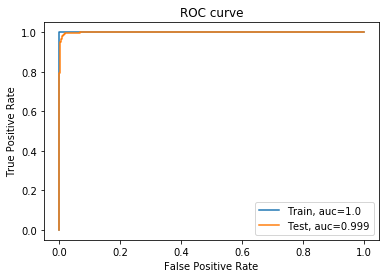

In [125]:
# Function to plot ROC curve 
roc_curve(gsc_mlp, X_train, y_train, X_test, y_test)

__Evaluation__: The optimized MLP is comparable to the random forest model. After tuning, the recall score remained the same while the precision score did improve by 0.13%. 

### Supervised Learning Results
Let's combine our modeling outputs in a crosstab for comparison. 

In [126]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forest',
                                           'Multi-Layer Perceptron  Neural Network'],
                                 'ROC_AUC': [gsc_lr_roc_auc, gsc_rf_roc_auc, gsc_mlp_roc_auc],
                                'Accuracy': [gsc_lr_accuracy, gsc_rf_accuracy, gsc_mlp_accuracy],
                                'Recall': [gsc_lr_recall, gsc_rf_recall, gsc_mlp_recall],
                                'Precision': [gsc_lr_precision, gsc_rf_precision, gsc_mlp_precision]})

# Horizontal bar chart of 
model_comparison.sort_values('ROC_AUC', ascending = False)

,Model,ROC_AUC,Accuracy,Recall,Precision
1,Random Forest,0.995480,0.995733,0.990961,1.000000
2,Multi-Layer Preceptron Neural Network,0.987011,0.986884,0.989287,0.983034
0,Logistic Regression,0.958375,0.957807,0.968530,0.943575


#### Which model performed best?
As we can see, all the models performed fairly well in across all metrics. However, the average scores of the random forest model with a 100% precision after hyperparameter tuning. 

# Unsupervised Learning: Clustering Accounts

In the previous section, we built several models to classify tweets and identified feature importance with random forest. We will continue to examine tweeting patterns from genuine and bot users through clustering. 

First, let's try to get a better understanding of what a tweet from a genuine user might consist of. 

In [127]:
# Drop text components 
df2 = df_clean.iloc[:,0:21]
df2.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,class,retweet_count,reply_count,favorite_count,num_hashtags,...,num_mentions,account_age_yr,digit_in_name,user_name_len,tweet_hour,tweet_month,tweet_day,tweet_year,tweet_length,num_of_words
0,11106,668,1287,1,2,1,0,0,0,0,...,0,9,0,11,0,9,22,2014,122,24
1,1505,717,1069,0,1,1,0,0,0,0,...,0,6,0,14,18,10,29,2014,82,13
2,9770,21460,2574,0,0,1,0,0,0,0,...,0,7,0,11,22,10,16,2014,42,8
3,12732,1149,932,1,16,1,0,0,0,0,...,0,9,2,11,0,9,24,2014,66,11
4,7975,398,350,11,2,1,0,0,0,1,...,0,10,0,14,21,7,12,2012,51,6


### Distinction between Genuine and Bot Tweets
Let's check if there are any tweeting obvious patterns in the data. 

In [128]:
# Groupby categories and take the mean
print(df2.groupby('class').mean())

       statuses_count  followers_count  friends_count  favourites_count  \
class                                                                     
0        22943.428392      2560.724342      779.36033       5166.262818   
1         9757.601045      2187.312374     1603.00904         67.130575   

       listed_count  retweet_count  reply_count  favorite_count  num_hashtags  \
class                                                                           
0         39.809015     811.971267          0.0        0.450570      0.240011   
1          9.804339       2.651868          0.0        0.129972      0.053937   

       num_urls  num_mentions  account_age_yr  digit_in_name  user_name_len  \
class                                                                         
0      0.140253      0.778307        8.213074       0.380533      10.827153   
1      0.324126      0.109783        7.060667       0.214343      11.912716   

       tweet_hour  tweet_month  tweet_day   tweet_year  t

__Observation__: Based on the summary, the average retweet count for genuine tweets is substantially higher than tweets by bots. Genuine tweets tend to contain more hashtags and mentions. Let's take a closer look at those features.

In [129]:
# Group by favourites_count groups and get the mean
df2.groupby('favourites_count').mean()

# Count the values of the observations in each favourites_count group
print(df2['favourites_count'].value_counts())

0       5057
1       4119
2        265
3         75
1416      57
        ... 
20         1
610        1
920        1
16         1
544        1
Name: favourites_count, Length: 796, dtype: int64


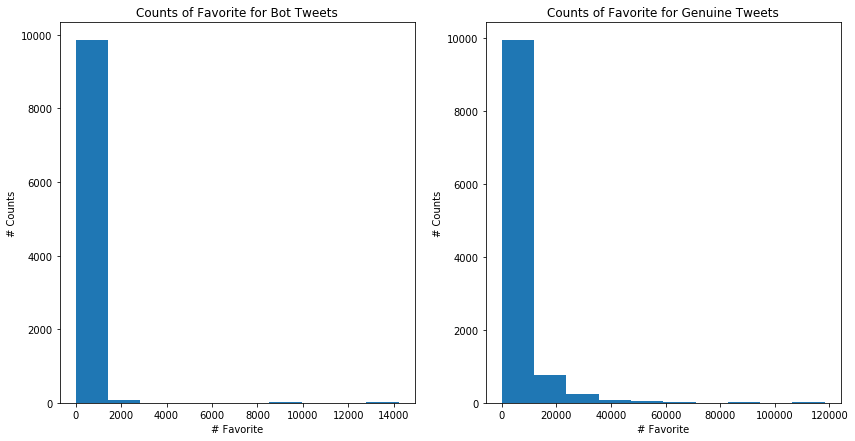

In [130]:
# Create two dataframes with fraud and non-fraud data 
bots = df2.loc[df2['class'] == 1] 
gen = df2.loc[df2['class'] == 0]

plt.figure(figsize=(14,7))

# Plot histograms of the retweet_count in bot and gen tweets
plt.subplot(1, 2, 1)
plt.hist(bots.favourites_count)
plt.xlabel('# Favorite')
plt.ylabel('# Counts')
plt.title('Counts of Favorite for Bot Tweets')

# Plot histograms of the num_mentions in bot and gen tweets
plt.subplot(1, 2, 2)
plt.hist(gen.favourites_count)
plt.xlabel('# Favorite')
plt.ylabel('# Counts')
plt.title('Counts of Favorite for Genuine Tweets')
plt.show()

__Observation__: The average favorite count for both genuine and bot tweets is less than 2 thousand. Some genuine tweets received more than 20,000 favorites. Celebrities may have posted these tweets.

In [131]:
# Group by num_mentions groups and get the mean
df2.groupby('retweet_count').mean()

# Count the values of the observations in each num_mentions group
print(df2['retweet_count'].value_counts())

0         16743
1          1353
2           396
3           217
4           141
          ...  
117424        1
4747          1
33385         1
585           1
839           1
Name: retweet_count, Length: 1044, dtype: int64


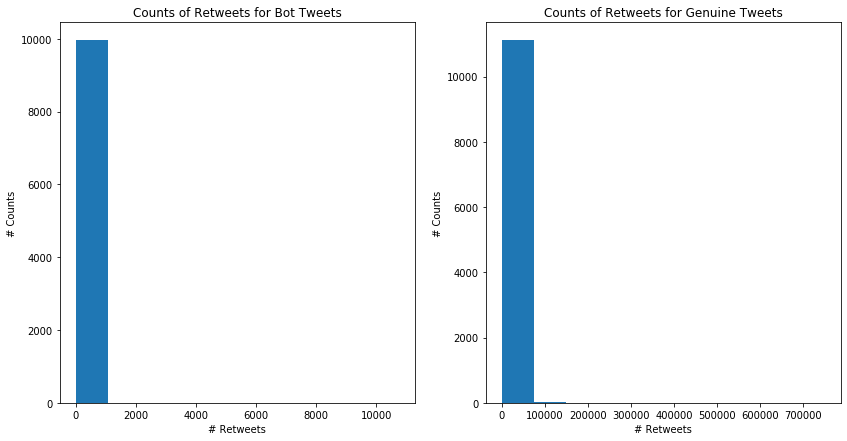

In [132]:
# Create two dataframes with fraud and non-fraud data 
bots = df2.loc[df2['class'] == 1] 
gen = df2.loc[df2['class'] == 0]

plt.figure(figsize=(14,7))

# Plot histograms of the retweet_count in bot tweets
plt.subplot(1, 2, 1)
plt.hist(bots.retweet_count)
plt.xlabel('# Retweets')
plt.ylabel('# Counts')
plt.title('Counts of Retweets for Bot Tweets')


# Plot histograms of the retweet_count in gen tweets
plt.subplot(1, 2, 2)
plt.hist(gen.retweet_count)
plt.xlabel('# Retweets')
plt.ylabel('# Counts')
plt.title('Counts of Retweets for Genuine Tweets')
plt.show()

__Observation__: We can observe several genuine tweets that have more than 100,000 retweets. This may have skewed the average retweet count for genuine tweets. Likewise with the number of mentions, there are a couple of tweets that consists of 6 mentions or more while the average mention is around 2 for genuine tweets.

## Clustering Pre-Processing 
Before we can begin clustering prepare the data by:

1. Normalize data
2. Reduce dimensions

In [134]:
# Define varaibles 
y = np.array(df2['class'])
X = np.array(df2.drop(['class'], 1).astype(float))

In [135]:
# Normalize the data.
X_norm = normalize(X)

### Reduce Dimensions: PCA vs TSNE
Let’s try out both reduction methods to see which works best in clustering genuine and bot tweets. 


In [136]:
# Utility function to visualize the outputs of t-SNE and PCA

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Principal Component Analysis 
PCA reduces the dimensionality of a data set by transforming the variables to a new set of variables (principle components) that retain the optimally weighted observed variables.

In [137]:
# PCA to reduce dimension to 2
time_start = time.time()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.06639218330383301 seconds


In [138]:
pca_df = pd.DataFrame(columns = ['pca1','pca2'])

pca_df['pca1'] = X_pca[:,0]
pca_df['pca2'] = X_pca[:,1]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.61775052 0.19753875]


(<Figure size 576x576 with 1 Axes>,
 [Text(-0.17848331998054065, 0.03877567143634155, '0'),
  Text(-0.2181635400834353, -0.14615632314633387, '1')])

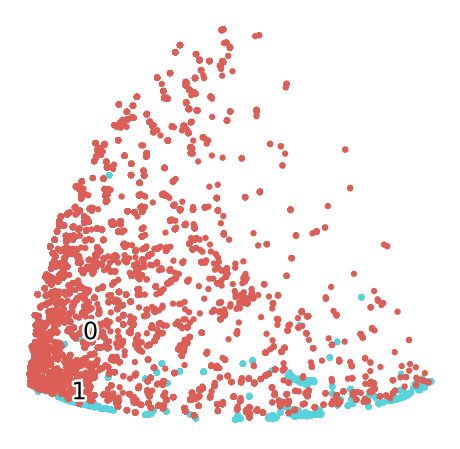

In [139]:
# Visualizing the PCA output
fashion_scatter(pca_df.values,y)

__Observation__: PCA was able to capture most of genuine tweets and reduced bot tweets to a small spare linear line shape. 

### TSNE

t-distributed Stochastic Neighbor Embedding converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.  

In [140]:
# TSNE to reduce dimension to 2
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, random_state=42)
X_tsne = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Summary of transformation
print(X_tsne.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21093 samples in 0.172s...
[t-SNE] Computed neighbors for 21093 samples in 2.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21093
[t-SNE] Computed conditional probabilities for sample 2000 / 21093
[t-SNE] Computed conditional probabilities for sample 3000 / 21093
[t-SNE] Computed conditional probabilities for sample 4000 / 21093
[t-SNE] Computed conditional probabilities for sample 5000 / 21093
[t-SNE] Computed conditional probabilities for sample 6000 / 21093
[t-SNE] Computed conditional probabilities for sample 7000 / 21093
[t-SNE] Computed conditional probabilities for sample 8000 / 21093
[t-SNE] Computed conditional probabilities for sample 9000 / 21093
[t-SNE] Computed conditional probabilities for sample 10000 / 21093
[t-SNE] Computed conditional probabilities for sample 11000 / 21093
[t-SNE] Computed conditional probabilities for sample 12000 / 21093
[t-SNE] Computed conditional probabilities for sam

In [141]:
X_tsne

array([[ 96.968346  ,   4.720887  ],
       [ 12.2814045 ,  15.088146  ],
       [ 51.544605  , -57.09998   ],
       ...,
       [-21.922243  , -35.791508  ],
       [-15.793839  ,   0.89722395],
       [  4.0231504 , -45.52847   ]], dtype=float32)

(<Figure size 576x576 with 1 Axes>,
 [Text(-2.4286723, -14.163455, '0'), Text(4.1601696, 14.4171505, '1')])

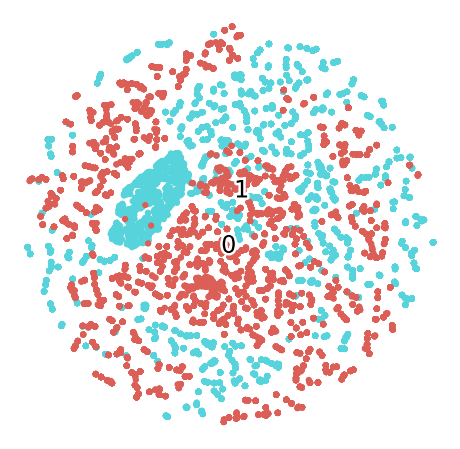

In [142]:
# Visualizing the TSNE output
fashion_scatter(X_tsne, y)

__Observation__: With TSNE, we can see several clusters of genuine and bots tweets.

### Which reduce dimension method to use?

We will continue with the TSNE transformation since the groups for genuine and bot tweets are more defined than in clusters produced by PCA.

### KMeans Classifer
Let's see KMeans is label tweets outside of it's centroid as tweets from robots.

In [143]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)

# Fit the model to the scaled data
kmeans.fit(X_tsne)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

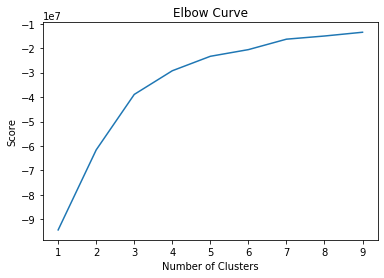

In [144]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_tsne).score(X_tsne) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

__Observation__: Based on the Elbow Curve, 3 appears to the optimal number of clusters. 

In [145]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.3, random_state=42)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create bot tweets predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [146]:
# Calculate metrics
km_roc_auc = roc_auc_score(y_test, km_y_pred)
km_accuracy = accuracy_score(y_test, km_y_pred)
km_recall = recall_score(y_test, km_y_pred)
km_precision = precision_score(y_test, km_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (km_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (km_accuracy * 100.0))
print('Recall: %.2f%%' % (km_recall * 100.0))
print('Precision: %.2f%%' % (km_precision * 100.0))
print(confusion_matrix(y_test, km_y_pred))

ROC_AUC: 49.28%
Accuracy: 51.44%
Recall: 4.25%
Precision: 40.38%
[[3127  189]
 [2884  128]]


__Evaluation__: Classifying tweets from robots based on cluster outliers is not a recommend techniques. The Kmean model was not able to distinguish differences between robot and genuine tweets.

## Tweets Segmentation 
In this section, we will perform clustering to examine tweet patterns within each cluster. 

### Metrics 
__Homogeneity__: measures how many members of a single class is within a cluster. Score ranges between 0.0 and 1.0. where 1.0 stands for perfectly homogeneous labeling.

__Silhouette Coefficient__: the mean distance between a sample and all other points in the same class (a), the mean distance between a sample and all other points in the next nearest cluster (b), divided by whichever of the two values is highest. A coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.[Resource](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

### KMeans
This algorithm partitions the dataset into clusters to form homogeneous groups. Through an iterative process, it places random centroids and groups the closest datapoint to centroids. The group mean distance to the centroid is calculated and the process will repeat until optimized.

__Assumptions__
 * Symmetric distribution of variables(not skewed)
 * Variables with same average values
 * Variables with same variance 
 

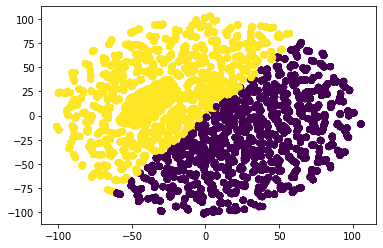

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      6153  4328
1      4984  5628


In [147]:
# Fit values
km1 = KMeans(n_clusters=2, random_state=42).fit(X_tsne)

# Obtain the predicted labels and calculate number of clusters
km1_y_pred = km1.labels_

# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km1_y_pred)
plt.show()

# Check the solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(km1_y_pred, y))

In [148]:
# Calculate metrics
km1_homo = homogeneity_score(y, km1_y_pred)
km1_sil = silhouette_score(X_tsne, km1_y_pred)

# Print metrics
print("Homogeneity: %0.3f" % km1_homo)
print("Silhouette Coefficient: %0.3f" % km1_sil)

Homogeneity: 0.010
Silhouette Coefficient: 0.335


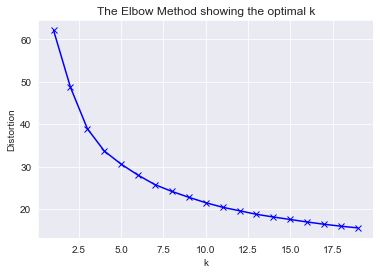

In [149]:
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_tsne)
    kmeanModel.fit(X_tsne)
    distortions.append(sum(np.min(cdist(X_tsne, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tsne.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

__Observation__: The elbow method recommends 5 clusters

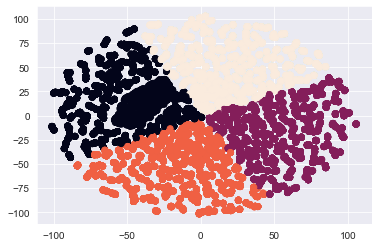

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      2839  2861
1      2748  2273
2      3699  1419
3      1851  3403


In [150]:
# Fit values
km2 = KMeans(n_clusters=4, random_state=42).fit(X_tsne)

# Obtain the predicted labels and calculate number of clusters
km2_y_pred = km2.labels_

# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km2_y_pred)
plt.show()

# Check the solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(km2_y_pred, y))

In [151]:
# Calculate metrics
km2_homo = homogeneity_score(y, km2_y_pred)
km2_sil = silhouette_score(X_tsne, km2_y_pred)

# Print metrics
print("Homogeneity: %0.3f" % km2_homo)
print("Silhouette Coefficient: %0.3f" % km2_sil)

Homogeneity: 0.051
Silhouette Coefficient: 0.352


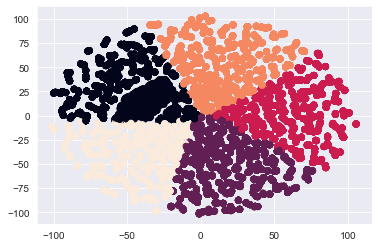

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      2416  2321
1      3001  1373
2      1836  2114
3      1418  2918
4      2466  1230


In [152]:
# Fit values
km3 = KMeans(n_clusters=5, random_state=42).fit(X_tsne)

# Obtain the predicted labels and calculate number of clusters
km3_y_pred = km3.labels_

# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km3_y_pred)
plt.show()

# Check the solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(km3_y_pred, y))

In [153]:
# Calculate metrics
km3_homo = homogeneity_score(y, km3_y_pred)
km3_sil = silhouette_score(X_tsne, km3_y_pred)

# Print metrics
print("Homogeneity: %0.3f" % km3_homo)
print("Silhouette Coefficient: %0.3f" % km3_sil)

Homogeneity: 0.052
Silhouette Coefficient: 0.328


### DBSCAN
Density-based spatial clustering of applications with noise (DBSCAN) is a density based method that groups together points with many nearby neighbors. Although we do not have to pre-select the number of clusters, we must define the minimum number of datapoints to make up a group. 

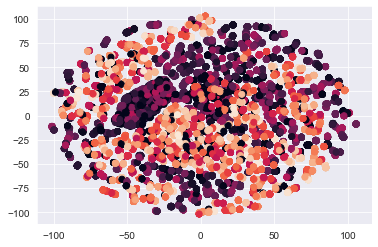

Comparing DBSCAN clusters against the data:
col_0    0    1
row_0          
-1     917  707
 0       0   19
 1       0   16
 2       0   16
 3       0   23
...    ...  ...
 1118   11    0
 1119   10    0
 1120   11    0
 1121    8    0
 1122   11    0

[1124 rows x 2 columns]


In [154]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_tsne)

# Obtain the predicted labels and calculate number of clusters
db_y_pred = db.labels_
n_clusters = len(set(db_y_pred)) - (1 if -1 in db_y_pred else 0)

# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=db_y_pred)
plt.show()

# Check the solution against the data
print('Comparing DBSCAN clusters against the data:')
print(pd.crosstab(db_y_pred, y))

In [155]:
# Calculate metrics
db_homo = homogeneity_score(y, db_y_pred)
db_sil = silhouette_score(X_tsne, db_y_pred)

# Print number of clusters
print('Estimated number of clusters: %d' % n_clusters)

# Print metrics
print("Homogeneity: %0.3f" % db_homo)
print("Silhouette Coefficient: %0.3f" % db_sil)

Estimated number of clusters: 1123
Homogeneity: 0.906
Silhouette Coefficient: 0.774


__Evaluation__: DBSCAN clustered the data into 1 group so we are unable to calculate silhouette score. This model was not able to form different clusters for tweet analysis.

### Mean-shift 
Mean shift clustering is a sliding-window-based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. 

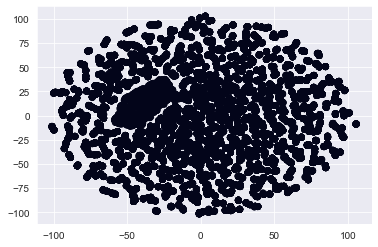

Comparing k-means clusters against the data:
col_0      0     1
row_0             
0      11137  9956
Number of estimated clusters: 1


In [156]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_tsne, quantile=0.2, n_samples=1000)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_tsne)

# Obtain the predicted labels and calculate number of clusters
ms_y_pred = ms.labels_

# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ms_y_pred)
plt.show()

# Check the solution against the data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(ms_y_pred, y))

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
ms_n_clusters = len(np.unique(ms_y_pred))

print("Number of estimated clusters: {}".format(ms_n_clusters))

In [ ]:
# Calculate metrics
ms_homo = homogeneity_score(y, ms_y_pred)
ms_sil = silhouette_score(X_tsne, ms_y_pred)

# Print metrics
print("Homogeneity: %0.3f" % ms_homo)
print("Silhouette Coefficient: %0.3f" % ms_sil)

# Note: ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

__Evaluation__: Like the DBSCAN model, Mean Shift model formed 1 group.

### Unsupervised Learning Results
Now, we will retrieve and compare our clustering results.

In [158]:
# Dataframe to hold the results
cluster_comparison = pd.DataFrame({'Model': ['KMeans (2 clusters)','KMeans (4 clusters)', 'KMeans (5 clusters)'],
                                 'Homogeneity': [km1_homo, km2_homo, km3_homo],
                                'Silhouette Coefficient': [km1_sil, km2_sil, km3_sil]})

# Horizontal bar chart of 
cluster_comparison.sort_values('Homogeneity', ascending = False)

,Model,Homogeneity,Silhouette Coefficient
2,KMeans (5 clusters),0.052350,0.328021
1,KMeans (4 clusters),0.051297,0.352230
0,KMeans (2 clusters),0.010021,0.334998


__Which clustering method should we use?__ <br>
Given that the data is round and dense, homogeneity score of each cluster should be weighted more than the silhouette coefficient. KMeans with 5 clusters had the highest homogeneity score noting that data points in the clusters were similar to each other.

## Cluster Analysis
Now, we will explore the trends within each cluster.

In [159]:
# Create a DataFrame by adding a new cluster label column
df3 = df2.assign(cluster=km3_y_pred)

# Group the data by cluster
print(df3.groupby(['cluster']).mean())


         statuses_count  followers_count  friends_count  favourites_count  \
cluster                                                                     
0          13103.773908       691.575047     661.886004       2650.717121   
1          14351.863969      2247.375857    1663.549383       3703.166667   
2          15412.035190      7417.871646    1403.901013       2802.902532   
3          18839.503921       995.871541    1280.573570        804.806504   
4          23066.661255       966.169913     846.752976       4028.630141   

         listed_count     class  retweet_count  reply_count  favorite_count  \
cluster                                                                       
0           12.435508  0.489973      81.311167          0.0        0.284991   
1           27.279378  0.313900     186.507316          0.0        0.360311   
2           64.013165  0.535190      32.640506          0.0        0.442278   
3           12.882149  0.672970      19.893911          0.0      

__Cluster 0__: This cluster consists of roughly an equal ratio of genuine and bot tweets. This cluster has the least amount of follower (691) and friend(661) count.

__Cluster 1__: Unlike Cluster 0, this group mainly consists of genuine tweets. This group is more popular than cluster 0 with an average follower count of 2,247 and average friend count of 1,663.

__Cluster 2__: Similar to cluster 0, this group contains an even ratio of genuine and bot tweets. Users in this group have the largest average following of 7,417.

__Cluster 3__: This cluster is made up of slightly more bot tweets with the lowest average favorite count (804) and lowest average of retweet count(19) per tweet. 

__Cluster 4__: Cluster 4 consists of half genuine and bot tweets. Although this group does not have the most followers or friends, this cluster contains the highest counts of favorite and retweets. 


# Conclusion

From supervised learning, we compared the performance of three different models (logistic regression, random forest, and neural network) to classifying a given Twitter user as bot or human.  We found that the random forest classifier had the best ROC AUC and precision on predictions. Textual features created from CountVectorization and TF-IDF transformation was helpful in classifying the user. Profile features such as favorite, status, and friends count played an important role in differentiating between the tweet types.

We continued to explore user patterns by clustering similar tweets. We used three clustering methods (KMeans, DBSCAN, and Mean-shift) to see which model would return sensible groups.  DBSCAN produced over a thousand groups and Mean-shift recommended one cluster. Thus, we used KMeans to partition the data into segments. Using the elbow method, 4 to 5 clusters was optimal. Clusters that consist of most genuine tweets had a larger following and a higher friend count. Groups with more bot tweets had a lower average of favorite and retweet counts. 

In future work, I would like to collect my own dataset to limit mismatch in the training and testing set. I would also like to expand on the English-only tweet corpus by incorporating features like tweet sentiment analysis and topic extraction. Learning about the evolution of bot accounts would also be helpful in classifying the different types of bot. The insights from this project can be used to build a web application that can classify Twitter users in real-time.